A6.9 Cubic Splines

In [4]:
import os
import sys

# add the directory containing the notebook to Python path
sys.path.append(os.getcwd())

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

status: optimal
optimal value: 7.844981009336876


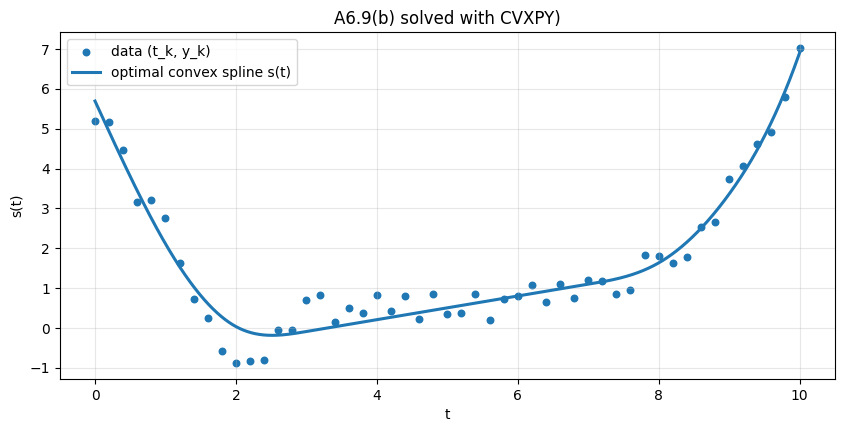

min enforced s'' on grid u: -4.440892098500626e-16
min s'' on fine grid: -4.440892098500626e-16


In [6]:
from bsplines import bsplines
import spline_data as sd  # contains arrays t, y

t = np.asarray(sd.t, dtype=float).ravel()
y = np.asarray(sd.y, dtype=float).ravel()
N = t.size

#M+3 = 13 basis functions
p = 13                     
G = np.zeros((N, p))
for k in range(N):
    g, _, _ = bsplines(float(t[k]))
    G[k, :] = np.asarray(g, dtype=float).ravel()

#enforce convexity restraints at K grid points
K = 800
u = np.linspace(0.0, 10.0, K)
G2 = np.zeros((K, p))
for i in range(K):
    _, _, gpp = bsplines(float(u[i]))
    G2[i, :] = np.asarray(gpp, dtype=float).ravel()

# fit the convex spline
theta = cp.Variable(p)
objective = cp.Minimize(cp.sum_squares(G @ theta - y))
constraints = [G2 @ theta >= 0]
prob = cp.Problem(objective, constraints)

try:
    prob.solve(solver=cp.OSQP, verbose=False)
except Exception:
    prob.solve(solver=cp.ECOS, verbose=False)

print("status:", prob.status)
print("optimal value:", prob.value)

theta_star = theta.value

#evaluate
ufine = np.linspace(0.0, 10.0, 1500)
s = np.zeros_like(ufine)
s2 = np.zeros_like(ufine)

for i, ui in enumerate(ufine):
    g, _, gpp = bsplines(float(ui))
    g = np.asarray(g, dtype=float).ravel()
    gpp = np.asarray(gpp, dtype=float).ravel()
    s[i] = g @ theta_star
    s2[i] = gpp @ theta_star

plt.figure(figsize=(10, 4.5))
plt.scatter(t, y, s=22, label="data (t_k, y_k)")
plt.plot(ufine, s, linewidth=2.2, label="optimal convex spline s(t)")
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("A6.9(b) solved with CVXPY)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("min enforced s'' on grid u:", float(np.min(G2 @ theta_star)))
print("min s'' on fine grid:", float(np.min(s2)))
